In [25]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.set_cmap("magma")

<Figure size 800x550 with 0 Axes>

## Test of the Shallow Water model

In [26]:
#from DA_PoC.dynamical_systems.sw_numerical_model 
from DA_PoC.dynamical_systems.examples.sw import SWModelJax
from DA_PoC.common.numerical_model import NumericalModel

from DA_PoC.common.observation_operator import LinearObservationOperator
import numpy as np

In [27]:
n_pts = 32
n_x = n_pts
dx = 5e3
n_y = n_pts
dy = 5e3
swmodel = SWModelJax(n_x, dx, n_y, dy, periodic_x=True)


In [28]:
state_dimension = 3 * swmodel.state_variable_length
obs_dimension = swmodel.state_variable_length
h_no_nan = np.eye(swmodel.state_variable_length)
for i in range(swmodel.state_variable_length):
    if i % n_pts == 0:
        h_no_nan[i, i] = 0
        h_no_nan[i-1, i-1] = 0

H_obs = np.hstack(
    [
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        h_no_nan,
    ]
)
obs_operator = LinearObservationOperator(Hmatrix=H_obs)
window = 50
# print(f"{lorenz.obs.shape=}")
# print(f"{lorenz.H=}")
numerical_model_sw = NumericalModel(state_dimension, obs_dimension)
background = np.zeros(state_dimension)
background[swmodel.slice_h] = swmodel.depth
numerical_model_sw.background = background
numerical_model_sw.background_error_cov_inv = 0.1 * np.eye(state_dimension)
numerical_model_sw.set_observation_operator(obs_operator)
def remove_nan(array):
    return np.where(np.isnan(array), 0, array)

# def forw(x):
#     x1 = remove_nan(swmodel.forward(x, n_steps=window, pbar=False))
#     return np.concatenate([x[:, None], x1[:, None]], axis=-1)
numerical_model_sw.set_forward(lambda x: remove_nan(swmodel.forward(x, n_steps=window, pbar=False)))
# numerical_model_sw.set_forward(forw)

numerical_model_sw.set_tangent_linear(
    lambda x: np.asarray(swmodel.forward_TLM(x, n_steps=window)[0])
)
x0_t = background
x0_t[swmodel.slice_h] += 3 * np.random.randn(swmodel.state_variable_length)

Observation operator set already


In [29]:
# new_state = numerical_model_sw.forward_no_obs(x0_t)
def generate_obs_no_noise(x0, n_steps):
    return remove_nan(swmodel.forward(x0, n_steps=n_steps)[swmodel.slice_h])

true_obs = generate_obs_no_noise(x0_t, window)


51it [00:06,  7.34it/s]                                                                                                                                                                


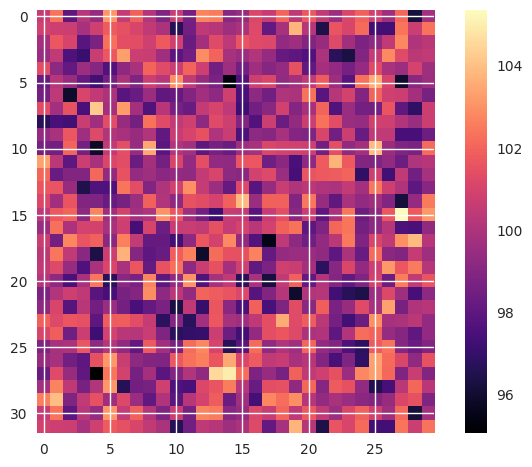

In [30]:
plt.imshow(true_obs.reshape(n_pts, n_pts)[:, 1:-1])
plt.colorbar()

In [31]:
x1 = x0_t + np.random.normal(size=x0_t.shape)

In [32]:
noisy_obs = true_obs +  np.random.normal(loc=0, scale=0.1, size=true_obs.shape)

In [33]:
numerical_model_sw.set_obs(noisy_obs)
print(numerical_model_sw.cost_function(x0_t + np.random.normal(size=x0_t.shape)))
print(numerical_model_sw.cost_function(x0_t))

1948.3841209243017
4.804965241113677


51it [00:31,  1.60it/s]                                                                                                                                                                


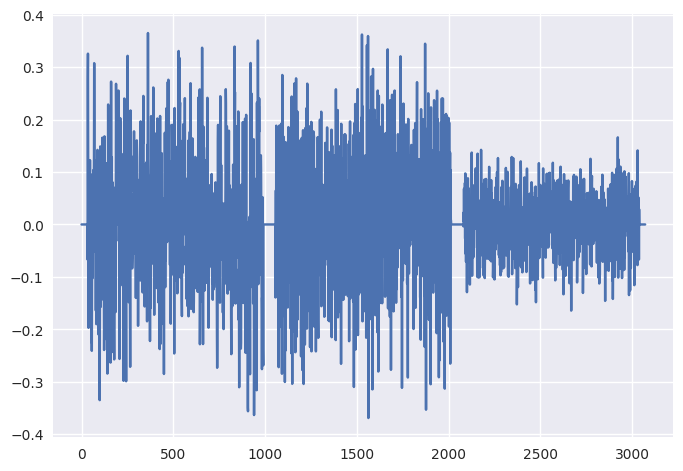

In [34]:
cost = numerical_model_sw.cost_function(x0_t)
grad = numerical_model_sw.gradient(x0_t)
plt.plot(grad)

In [35]:
gn = numerical_model_sw.gauss_newton_hessian_matrix(x1)

51it [00:32,  1.55it/s]                                                                                                                                                                


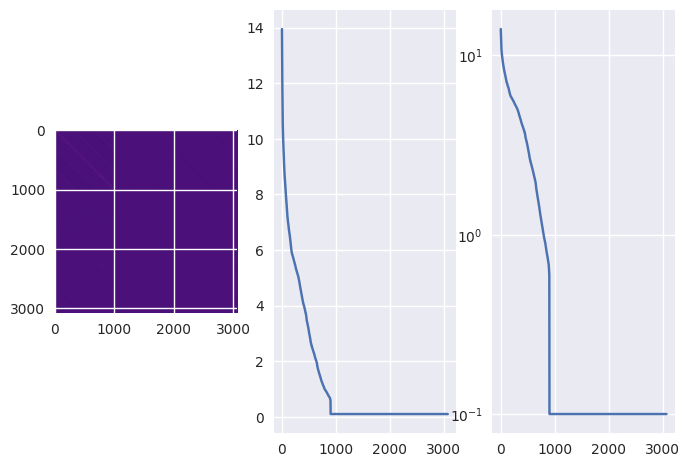

In [36]:
plt.subplot(1, 3, 1)
plt.imshow(gn)
plt.subplot(1, 3, 2)
plt.plot(np.linalg.svd(gn, compute_uv=False))
plt.subplot(1, 3, 3)
plt.plot(np.linalg.svd(gn, compute_uv=False))
plt.yscale('log')

In [37]:
np.linalg.cond(gn)

139.51135352417393

In [38]:
import os
os.getcwd()
from datetime import date, datetime

[  1.98249395   0.18567043   1.30458241 ...  99.30981301  92.61080916
 104.61488307]


1898.4470271607338

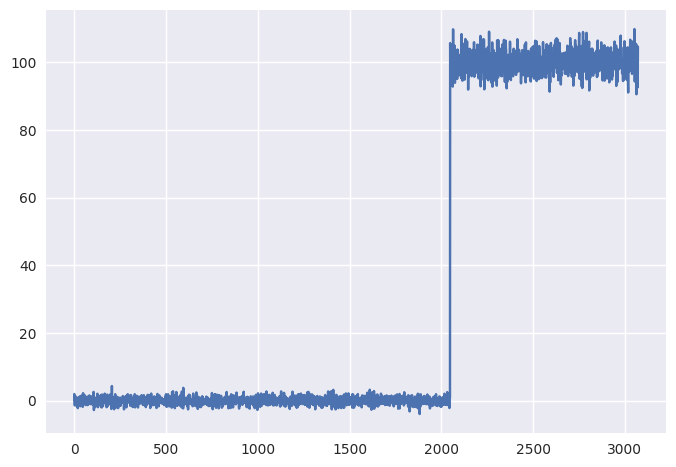

In [39]:
plt.plot(x1)
print(x1)
numerical_model_sw.cost_function(x1)

In [40]:
# exp_name = datetime.now().strftime("%H:%M:%S")
# gn_result = numerical_model_sw.GNmethod(
#     x1,
#     verbose=True,
#     prec=None,
#     log_file=os.path.join(os.getcwd(), "log_sw.txt"),
#     exp_name=exp_name,
#     i_cycle=0,
# )
# gn_x = gn_result['gn_x']

In [41]:
exp_name = datetime.now().strftime("%H:%M:%S")
numerical_model_sw.r = 500
gn_result = numerical_model_sw.GNmethod(
    x0_t + 2 * np.random.normal(size=x0_t.shape),
    verbose=True,
    log_file=os.path.join(os.getcwd(), "log_sw.txt"),
    exp_name=exp_name,
    i_cycle=0,
    prec = 'spectralLMP'
)
gn_x = gn_result['gn_x']



    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:30,  1.69it/s]                                                                                                                                                                
51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:31,  1.64it/s]                                                                                                                                                                


14:48:26,     0,     0, 7561.5707,       10, -3969.09, 1.467e+02, 3.133e+01


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 36/50 [00:22<00:08,  1.59it/s]


KeyboardInterrupt: 

In [ ]:
GtG = numerical_model_sw.gauss_newton_hessian_matrix(x0_t + 2 * np.random.normal(size=x0_t.shape))

151it [01:30,  1.67it/s]                         


In [ ]:
w, v = np.linalg.eig(GtG)
wh, vh = np.linalg.eigh(GtG)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


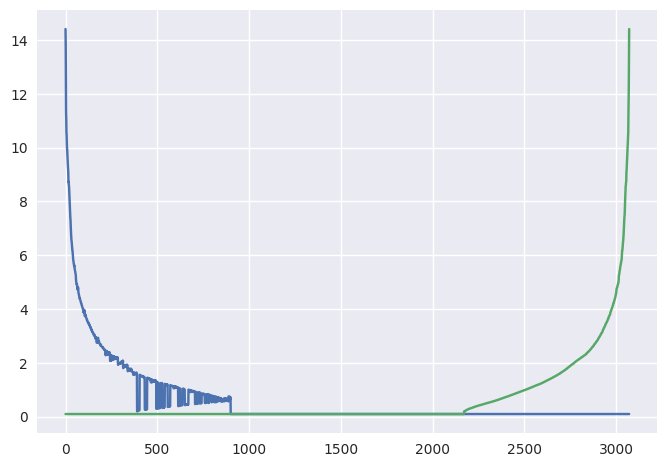

In [ ]:
plt.plot(w)
plt.plot(wh)

[ 1.57393631  0.86991623  0.27380623 ... -1.20513843 -0.24107467
 -0.24070549]


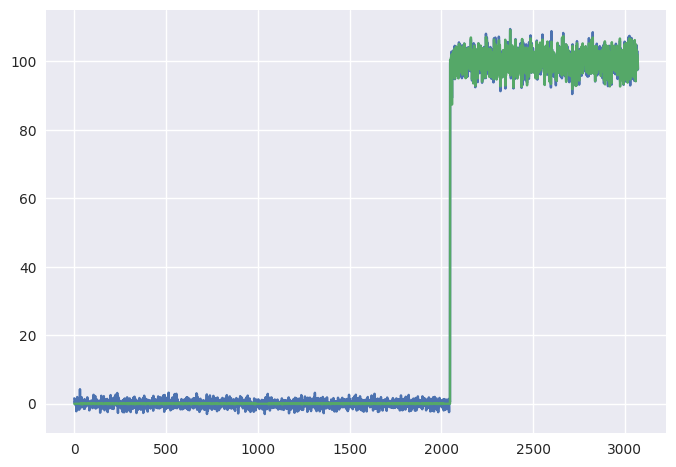

In [ ]:
plt.plot(x1)
plt.plot(gn_x)
print(x1 - gn_x)

## Data Assimilation

In [42]:
from DA_PoC.variational.incrementalCG import Incremental4DVarCG

In [43]:
# print(background.shape)
x_t = numerical_model_sw.forward_no_obs(background + np.random.normal(size=background.shape))
truth = numerical_model_sw.obs_operator(x_t)
print(x_t.shape, truth.shape)


(3072,) (1024,)


In [44]:
numerical_model_sw.n

3072

In [45]:
np.concatenate([truth[:, None], truth[:, None]], axis=-1).shape

(1024, 2)

In [46]:
def get_next_obs(x0, sigma_obs=1.0):
    x_t = numerical_model_sw.forward_no_obs(x0)
    truth = numerical_model_sw.obs_operator(x_t)
    truth = np.concatenate([truth[:, None], truth[:, None]], axis=-1)
    obs = truth + sigma_obs * np.random.normal(size = truth.shape)
    obs = np.concatenate([obs[:, None], obs[:, None]], axis=-1)
    return x_t, x_t, truth
numerical_model_sw.nobs = 1

In [47]:
DA_exp = Incremental4DVarCG(
    state_dimension=numerical_model_sw.n,
    bounds=None,
    numerical_model=numerical_model_sw,
    observation_operator=obs_operator,
    x0_run=x0_t,
    x0_analysis=None,
    get_next_observations=get_next_obs,
    n_cycle=2,
    n_outer=3,
    n_inner=20,
    prec=None,
    plot=False,
    log_append=False,
    save_all=False
)


In [48]:
DA_exp.run()

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:30,  1.68it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                


 default,     0,     0, 1820.3153,       20, -3995.11, 1.385e+02, 1.385e+02


51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:31,  1.64it/s]                                                                                                                                                                
51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:30,  1.66it/s]                                                                                                                                                                


 default,     0,     1,  11.1381,       20, -4003.86, 1.356e+02, 1.356e+02


51it [00:32,  1.59it/s]                                                                                                                                                                
51it [00:32,  1.59it/s]                                                                                                                                                                
51it [00:32,  1.59it/s]                                                                                                                                                                
51it [00:30,  1.66it/s]                                                                                                                                                                


 default,     0,     2,   0.0003,       20, -4003.93, 1.356e+02, 1.356e+02
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:33,  1.54it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                
51it [00:32,  1.59it/s]                                                                                                                                                                


 default,     1,     0, 32603.8721,       20, -4006.49, 1.353e+02, 1.353e+02


51it [00:31,  1.60it/s]                                                                                                                                                                
51it [00:30,  1.67it/s]                                                                                                                                                                
51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:32,  1.56it/s]                                                                                                                                                                


 default,     1,     1, 122.2779,       20, -4000.28, 1.382e+02, 1.382e+02


51it [00:31,  1.64it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:32,  1.56it/s]                                                                                                                                                                
51it [00:31,  1.60it/s]                                                                                                                                                                


 default,     1,     2, 104.8771,       20, -4000.33, 1.383e+02, 1.383e+02


{'truth_full': None,
 'analysis_full': None,
 'obs_full': None,
 'n_iter_innerloop': [array([20., 20., 20.]), array([20., 20., 20.])],
 'cost_outerloop': [array([1.82031534e+03, 1.11380811e+01, 3.09471769e-04, 4.84000000e+02]),
  array([32603.87212936,   122.27790507,   104.87706196,   342.54657387])],
 'sp_optimisation': [],
 'quad_errors': [[], []],
 'l_model': <DA_PoC.common.numerical_model.NumericalModel at 0x7f431c535f30>,
 'inner_res_cycle': [[{'success': False,
    'niter': 20,
    'residuals': [array([-0.19619824, -0.0782893 , -0.18411688, ...,  0.10940869,
            -0.06825778, -0.07178467]),
     array([-0.193286  , -0.07712722, -0.18138397, ...,  0.10778469,
            -0.0672446 , -0.07071914]),
     array([-0.19001734, -0.07582293, -0.17831659, ...,  0.10596195,
            -0.06610743, -0.06952321]),
     array([-0.18580571, -0.07414235, -0.1743643 , ...,  0.10361336,
            -0.0646422 , -0.06798227]),
     array([-0.17933481, -0.07156026, -0.16829185, ...,  0.10

In [49]:
from datetime import datetime
import os

In [50]:
numerical_model_sw.r = 50
DA_spectral = Incremental4DVarCG(
    state_dimension=numerical_model_sw.n,
    bounds=None,
    numerical_model=numerical_model_sw,
    observation_operator=obs_operator,
    x0_run=x0_t,
    x0_analysis=None,
    get_next_observations=get_next_obs,
    n_cycle=5,
    n_outer=3,
    n_inner=100,
    prec="spectralLMP",
    plot=False,
    log_append=False,
    save_all=False
)

In [51]:
DA_spectral.run()

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:32,  1.55it/s]                                                                                                                                                                
51it [00:30,  1.68it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                


 default,     0,     0, 1918.6651,       48, -3995.46, 1.401e+02, 8.668e+01


51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:31,  1.64it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                


 default,     0,     1,  13.3776,       44, -4003.90, 1.358e+02, 8.612e+01


51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:31,  1.60it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                


 default,     0,     2,   0.0002,       34, -4003.93, 1.356e+02, 8.616e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:31,  1.64it/s]                                                                                                                                                                
51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:33,  1.54it/s]                                                                                                                                                                


 default,     1,     0, 32603.8723,       44, -4006.49, 1.353e+02, 8.545e+01


51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:30,  1.69it/s]                                                                                                                                                                
51it [00:34,  1.49it/s]                                                                                                                                                                
51it [00:32,  1.55it/s]                                                                                                                                                                


 default,     1,     1, 122.2801,       44, -4000.28, 1.382e+02, 8.591e+01


51it [00:32,  1.55it/s]                                                                                                                                                                
51it [00:32,  1.56it/s]                                                                                                                                                                
51it [00:32,  1.57it/s]                                                                                                                                                                
51it [00:30,  1.65it/s]                                                                                                                                                                


 default,     1,     2, 104.8769,       38, -4000.33, 1.383e+02, 8.591e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:32,  1.57it/s]                                                                                                                                                                
51it [00:31,  1.60it/s]                                                                                                                                                                
51it [00:32,  1.59it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                


 default,     2,     0, 33975.3700,       46, -4003.75, 1.359e+02, 8.566e+01


51it [00:32,  1.59it/s]                                                                                                                                                                
51it [00:33,  1.54it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                
51it [00:30,  1.66it/s]                                                                                                                                                                


 default,     2,     1, 101.9690,       45, -4000.33, 1.385e+02, 8.607e+01


51it [00:32,  1.57it/s]                                                                                                                                                                
51it [00:33,  1.53it/s]                                                                                                                                                                
51it [00:30,  1.67it/s]                                                                                                                                                                
51it [00:32,  1.59it/s]                                                                                                                                                                


 default,     2,     2,  56.5228,       38, -4000.41, 1.384e+02, 8.600e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:31,  1.60it/s]                                                                                                                                                                
51it [00:31,  1.60it/s]                                                                                                                                                                
51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:31,  1.60it/s]                                                                                                                                                                


 default,     3,     0, 34628.2418,       46, -4003.52, 1.355e+02, 8.565e+01


51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:31,  1.63it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                
51it [00:30,  1.68it/s]                                                                                                                                                                


 default,     3,     1, 123.1837,       44, -4001.15, 1.383e+02, 8.602e+01


51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:32,  1.57it/s]                                                                                                                                                                
51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:31,  1.62it/s]                                                                                                                                                                


 default,     3,     2,  97.2101,       38, -4001.13, 1.387e+02, 8.594e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:31,  1.62it/s]                                                                                                                                                                
51it [00:31,  1.61it/s]                                                                                                                                                                
51it [00:33,  1.53it/s]                                                                                                                                                                


 default,     4,     0, 34057.1238,       47, -4004.11, 1.357e+02, 8.550e+01


51it [00:32,  1.58it/s]                                                                                                                                                                
51it [00:30,  1.65it/s]                                                                                                                                                                
51it [00:33,  1.54it/s]                                                                                                                                                                
51it [00:32,  1.59it/s]                                                                                                                                                                


 default,     4,     1, 113.5100,       44, -4000.55, 1.393e+02, 8.610e+01


51it [00:31,  1.61it/s]                                                                                                                                                                
51it [00:33,  1.52it/s]                                                                                                                                                                
51it [00:32,  1.55it/s]                                                                                                                                                                
51it [00:30,  1.68it/s]                                                                                                                                                                


 default,     4,     2,  81.7541,       38, -4000.63, 1.395e+02, 8.597e+01


{'truth_full': None,
 'analysis_full': None,
 'obs_full': None,
 'n_iter_innerloop': [array([48., 44., 34.]),
  array([44., 44., 38.]),
  array([46., 45., 38.]),
  array([46., 44., 38.]),
  array([47., 44., 38.])],
 'cost_outerloop': [array([1.91866508e+03, 1.33776239e+01, 2.47554203e-04, 3.42546574e+02]),
  array([32603.87225712,   122.28009655,   104.87693543,   342.54657387]),
  array([33975.36999636,   101.96895825,    56.5228085 ,   342.54657387]),
  array([34628.24176405,   123.18368379,    97.21014674,   457.22222222]),
  array([34057.12375657,   113.51003957,    81.75413726,   457.22222222])],
 'sp_optimisation': [],
 'quad_errors': [[], [], [], [], []],
 'l_model': <DA_PoC.common.numerical_model.NumericalModel at 0x7f431c535f30>,
 'inner_res_cycle': [[{'success': True,
    'niter': 48,
    'residuals': [array([-0.05639399, -0.08584876,  0.16400951, ..., -0.08460433,
            -0.0469526 , -0.08655543]),
     array([-0.05541041, -0.08435146,  0.16114899, ..., -0.08312874,
   

baseline: log(residuals) = 3.29 +  -0.39 * i
First 20 it, baseline: log(residuals) = 2.34 +  -0.29 * i
spectralLMP: log(residuals) = 2.89 +  -0.47 * i
First 20 it, spectralLMP: log(residuals) = 2.41 +  -0.41 * i


array([[1.20896463e+02, 3.83853420e+01, 1.91638393e+01, 1.19851221e+01,
        8.82025105e+00, 7.75532543e+00, 7.92627560e+00, 9.05497560e+00,
        8.90543848e+00, 7.17940200e+00, 4.75430253e+00, 2.78619795e+00,
        1.71105985e+00, 1.04953174e+00, 6.22766546e-01, 3.40533664e-01,
        1.92782957e-01, 1.08693029e-01, 6.77124200e-02, 4.29191094e-02,
        2.48318648e-02, 1.44188298e-02, 8.56614738e-03, 4.89856651e-03,
        2.80922515e-03, 1.54819705e-03, 9.43197245e-04, 5.69516946e-04,
        3.41181037e-04, 1.94913685e-04, 1.06268705e-04, 6.35177532e-05,
        3.59749081e-05, 2.16505246e-05, 1.30897938e-05, 7.42308030e-06,
        4.18094165e-06, 2.34311438e-06, 1.43670756e-06, 8.24824530e-07,
        4.97632211e-07, 2.88253139e-07, 1.66926349e-07, 9.50064390e-08,
        5.33173089e-08, 3.23447239e-08, 1.95833119e-08, 1.18749294e-08,
        7.06385276e-09],
       [9.44287386e+00, 3.71121710e+00, 2.16142427e+00, 1.23663714e+00,
        7.71563096e-01, 4.37965558e-01,

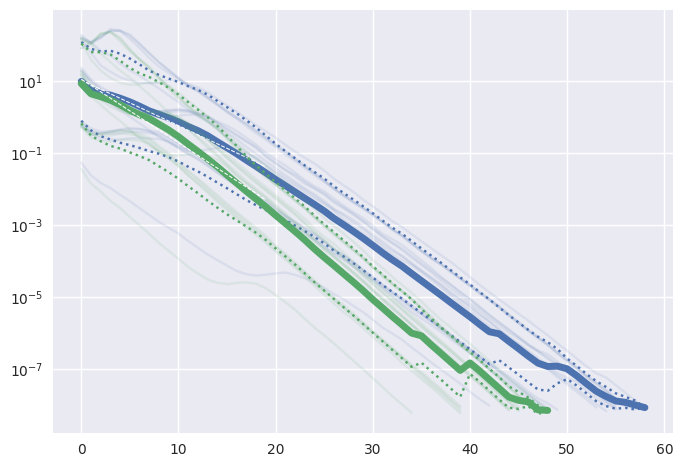

In [ ]:
DA_exp.plot_residuals_inner_loop(color='C0', label='baseline')
DA_spectral.plot_residuals_inner_loop(color='C1', label='spectralLMP')